# TRAINING

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pprint import pprint
import glob
import cv2

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import image

#from plot_keras_history import show_history, plot_history

In [2]:
# Le dossier des images d'entraînement qui contient un dossier C et un dossier NC
DATA = "/kaggle/input/train-missing-stud-lh07-v6/train_missing_stud_LH07"

In [3]:
# Choix défaut

#NOM_DEFAUT = "LH03_missing_tape"
#NOM_DEFAUT = "LH04_double_tape"
#NOM_DEFAUT = "LH04_short_tape"
#NOM_DEFAUT = "LH05_tilted_tape"
#NOM_DEFAUT = "RH07_missing_tape"
NOM_DEFAUT = "LH07_missing_stud"

In [4]:
match = {"LH03_missing_tape":["LH",
                              "_03_",
                              "model_missing_tape_LH03",0.09,0.18,0.05,0.25],
        "LH04_double_tape":["LH",
                            "_04_",
                            "model_double_tape_LH04",0.3,0.4,0,0.07],
        "LH04_short_tape":["LH",
                            "_04_",
                            "model_short_tape_LH04",0.3,0.4,0,0.22],
        "LH05_tilted_tape":["LH",
                            "_05_",
                            "model_tilted_tape_LH05",0.4,0.49,0.78,1],
        "RH07_missing_tape":["RH",
                            "_07_",
                            "model_missing_tape_RH07",0.62,0.73,0.78,0.91],
        "LH07_missing_stud":["LH",
                            "_07_",
                            #"model_missing_stud_LH07",0.52,0.65,0.25,0.41]}
                             "model_missing_stud_LH07",0.57,0.6,0.31,0.37]}

In [5]:
PREFIX = match[NOM_DEFAUT][0]
SUFFIX = match[NOM_DEFAUT][1]
MODEL = match[NOM_DEFAUT][2]
COEF_X1 = match[NOM_DEFAUT][3]
COEF_X2 = match[NOM_DEFAUT][4]
COEF_Y1 = match[NOM_DEFAUT][5]
COEF_Y2 = match[NOM_DEFAUT][6]

In [6]:
shutil.rmtree("/kaggle/working/",ignore_errors=True)

In [7]:
LISTE_DEFAUT = os.listdir(os.path.join(DATA,"NC"))

CPU times: user 381 ms, sys: 14.4 ms, total: 396 ms
Wall time: 515 ms


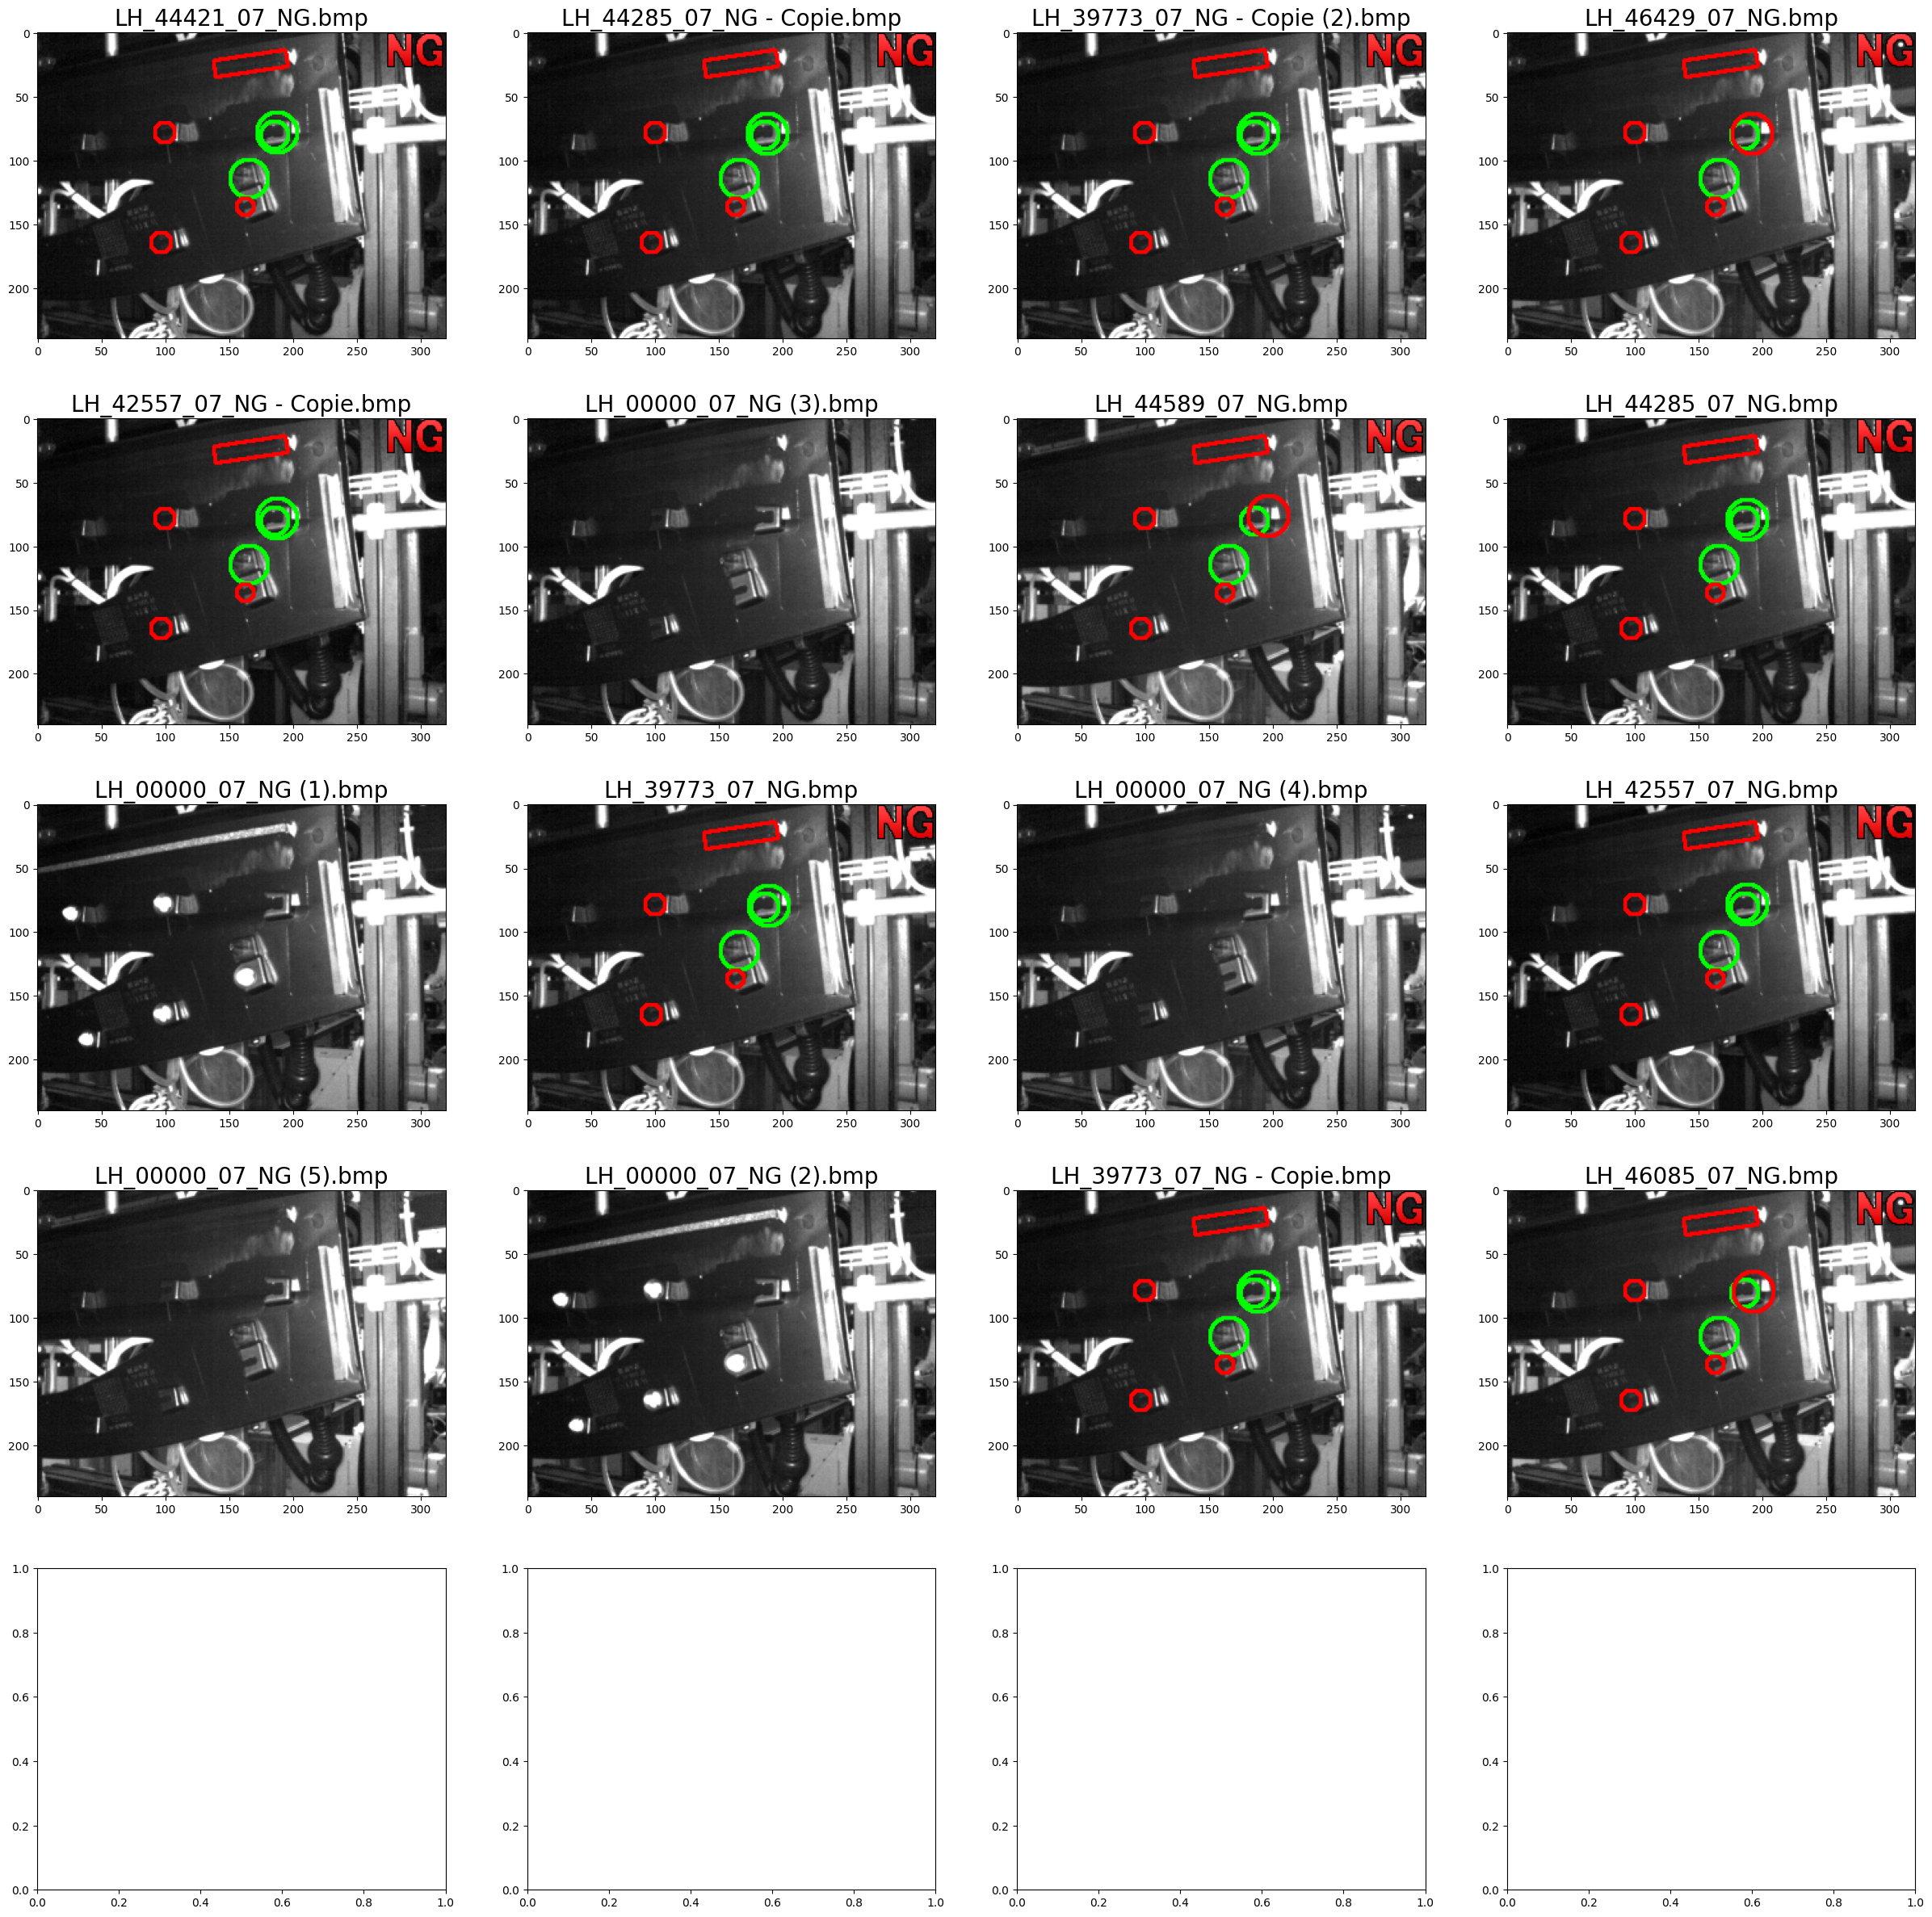

In [8]:
%%time
# Visualisons les images de défaut pour l'entraînement
fig, ax = plt.subplots(1+len(LISTE_DEFAUT)//4, 4, figsize=(30,30))
ax = ax.flatten()
for idx, path in enumerate(LISTE_DEFAUT):
    img = os.path.join(DATA,"NC", path)
    #assert img est une image
    ax[idx].imshow(plt.imread(img))
    ax[idx].set_title(path, fontsize=20)

# Approche avec préparation des images
on va extraire un morceau des images et on va entraîner le modèle sur ces morceaux.

on définit les bords de la fenêtre à extraire sur chaque image.

In [9]:
img = plt.imread(glob.glob(f"{DATA}/NC/*")[0])
taille_image = img.shape
taille_image

(240, 320, 3)

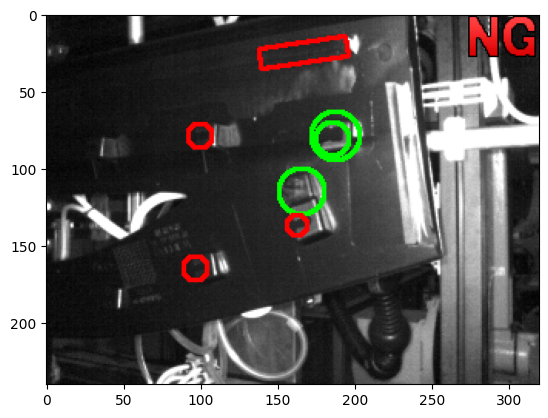

In [10]:
plt.imshow(img)

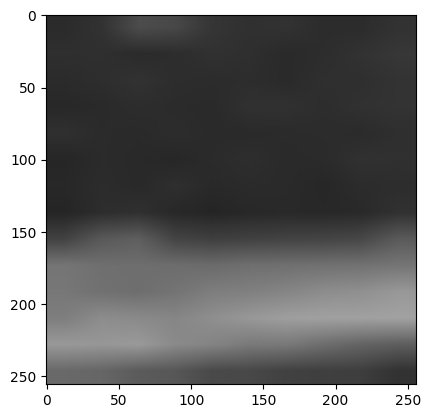

In [11]:
y_start, y_end = int(taille_image[0]*COEF_Y1), int(taille_image[0]*COEF_Y2)
x_start, x_end = int(taille_image[1]*COEF_X1), int(taille_image[1]*COEF_X2)
img_cropped = img[y_start:y_end, x_start:x_end]
img_cropped = cv2.resize(img_cropped, (256, 256))
plt.imshow(img_cropped)

## Création de nouveaux dossiers d'entraînement et de validation avec les images préparées

In [12]:
#crée un dossier dir_crop à partir du dossier dir avec des sous dossiers "C" et "NC" qui reprend les images de dir en les réduisant
def preparation_image(dir_source, dir_crop):
    
    for img in glob.glob(os.path.join(dir_source, '**', f"{PREFIX}*{SUFFIX}*.bmp"), recursive=True):
        # Load the image
        image_path = img 
        image = cv2.imread(image_path)

        # Crop the window
        cropped_image = image[y_start:y_end, x_start:x_end]

        # Créer le dossier s'il n'existe pas
        dossier = dir_crop #+ r"/C"
        os.makedirs(dossier, exist_ok=True)

        # Chemin d'accès pour sauvegarder l'image préparée
        cropped_image_path = os.path.join(dossier, os.path.basename(img))

        # Sauvegarder l'image au même nom que l'image d'origine
        cv2.imwrite(cropped_image_path, cropped_image)

In [13]:
%%time
# 13s
# Définir les chemins vers les répertoires d'entraînement et de validation
DATA_CROP_TRAIN = "/kaggle/working/data/DATA_CROP_TRAIN"

os.makedirs("/kaggle/working/data/DATA_CROP_TRAIN/C", exist_ok=True)
os.makedirs("/kaggle/working/data/DATA_CROP_TRAIN/NC", exist_ok=True)

preparation_image(os.path.join(DATA,"C"), os.path.join(DATA_CROP_TRAIN, "C"))
preparation_image(os.path.join(DATA,"NC"), os.path.join(DATA_CROP_TRAIN, "NC"))

CPU times: user 50.4 ms, sys: 110 ms, total: 160 ms
Wall time: 3.16 s


In [14]:
len(os.listdir(os.path.join(DATA,"NC")))
#len(os.listdir(os.path.join(DATA_CROP_TRAIN, "NC")))

16

In [15]:
# Test
assert len(os.listdir(os.path.join(DATA,"C"))) == len(os.listdir(os.path.join(DATA_CROP_TRAIN, "C"))), print("DATA-C et DATA_CROP_TRAIN-C pas de la même taille ou PREFIX et SUFFIX incorrects à la base")
assert len(os.listdir(os.path.join(DATA,"NC"))) == len(os.listdir(os.path.join(DATA_CROP_TRAIN, "NC"))), print("DATA-NC et DATA_CROP_TRAIN-NC pas de la même taille ou PREFIX et SUFFIX incorrects à la base")

## Augmentation des données

In [16]:
# Créer un générateur d'images sans augmentation de données
datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=1,
                                   width_shift_range=0.2,
                                   height_shift_range=False,
                                   horizontal_flip=False,
                                   validation_split=0.25,
                                   preprocessing_function=preprocess_input)

datagen_test = ImageDataGenerator(rescale=1./255,
                               height_shift_range=False,
                               horizontal_flip=False,
                               validation_split=0,
                               preprocessing_function=preprocess_input)

# Charger les images depuis le répertoire
train_generator = datagen_train.flow_from_directory(
    DATA_CROP_TRAIN,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_train.flow_from_directory(
    DATA_CROP_TRAIN,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen_test.flow_from_directory(
    DATA_CROP_TRAIN,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    subset=None
)

Found 243 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


## Instanciation et entraînement du modèle

In [17]:
# Charger le modèle VGG16 sans les couches supérieures (top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Figer les couches de base (optionnel)
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [18]:
os.makedirs("/kaggle/working/models",exist_ok=True)

In [19]:
# Ajouter des couches personnalisées pour la classification
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy','recall'])

# Création du callback
model_save_path = f"/kaggle/working/models/{MODEL}v5.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Entraîner le modèle
model.fit(
    train_generator,
    epochs=50,
    callbacks=callbacks_list,
    validation_data=val_generator
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-07 17:23:30.357361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-07-07 17:23:30.357421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-07-07 17:23:30.357435: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-07-07 17:23:30.357449: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-07-07 17:23:30.357460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

 16/243 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7887 - loss: 1618.9834 - recall: 0.7887

I0000 00:00:1720373012.503509      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/243 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9264 - loss: 2549.6091 - recall: 0.9264
Epoch 1: val_loss improved from inf to 0.00000, saving model to /kaggle/working/models/model_missing_stud_LH07v5.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9272 - loss: 2522.6204 - recall: 0.9272 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 2/50
241/243 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - recall: 1.0000
Epoch 2: val_loss did not improve from 0.00000
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 3/50
241/243 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - recall: 1.0000
Epoch 3: val_loss did not improve from 0.00000
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - va

In [20]:
# Score du dernier epoch

loss, accuracy, recall = model.evaluate(train_generator, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))

loss, accuracy, recall = model.evaluate(val_generator, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - recall: 1.0000
Training Accuracy   : 1.0000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - recall: 1.0000
Validation Accuracy :  1.0000


In [21]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy, recall = model.evaluate(val_generator, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy, recall = model.evaluate(test_generator, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  1.0000
Test Accuracy       :  1.0000


In [22]:
# Créer un générateur d'images pour la prédiction
predict_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

# Spécifiez le répertoire contenant les images pour la prédiction
PREDICT_DIR = DATA_CROP_TRAIN

predict_generator = predict_datagen.flow_from_directory(
    PREDICT_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Faire les prédictions
predictions = model.predict(predict_generator, steps=len(predict_generator), verbose=1)

# Récupérer les noms de fichiers pour lier les prédictions aux images
filenames = predict_generator.filenames

Found 324 images belonging to 2 classes.
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [23]:
# Exporter la liste des fichier au format json
liste_defaut_crop = []
for filename, prediction in zip(filenames, predictions):
    predicted_class = np.argmax(prediction)
    if predicted_class == 1:
        liste_defaut_crop.append(os.path.basename(filename))

In [24]:
# test
#assert len(liste_defaut_crop)>0, print("ERREUR : pas de défaut détecté")
if len(liste_defaut_crop) == 0 :
    print("Pas de défaut détecté !")

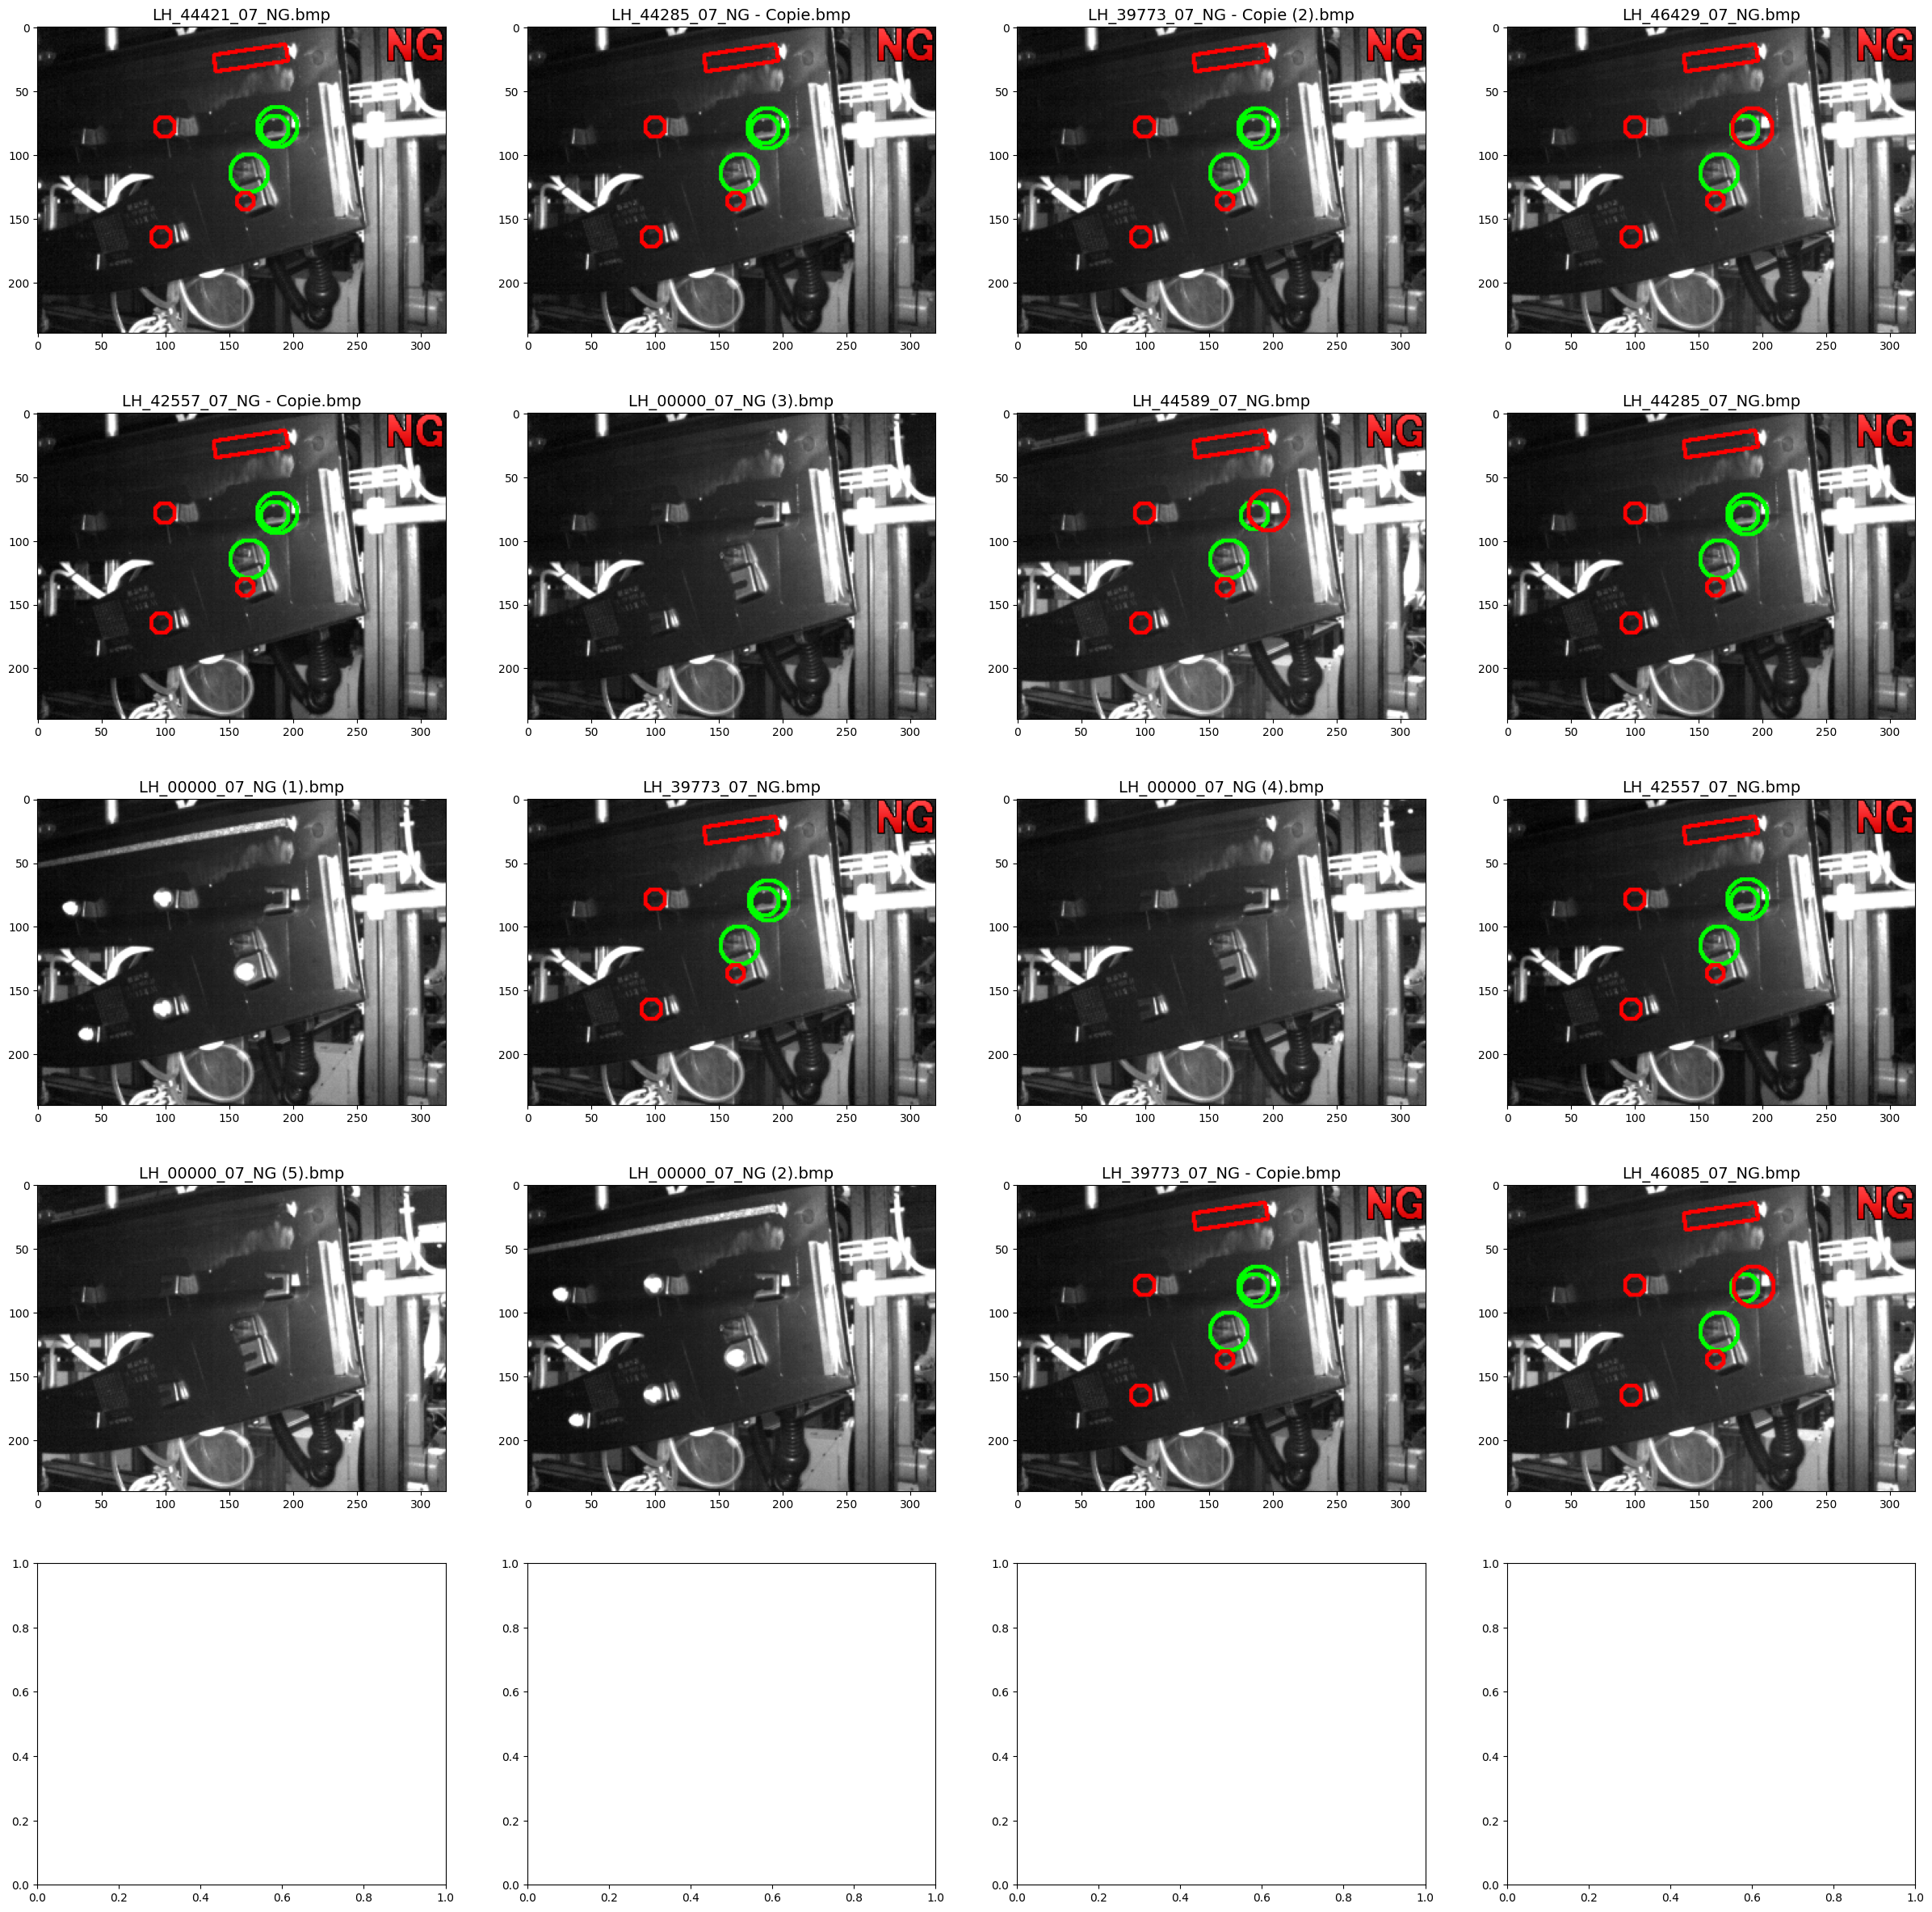

In [25]:
# Visualiser les prédictions de défaut
# Associer chaque fichier d'image à sa prédiction

idx = 0
fig, ax = plt.subplots(1+len(liste_defaut_crop)//4, 4, figsize=(30,30))
ax = ax.flatten()
for file in glob.glob(f"{DATA}/*/*.bmp"):
    name = os.path.basename(file)
    if name in liste_defaut_crop:
        ax[idx].imshow(plt.imread(file))
        ax[idx].set_title(name, fontsize=14)
        idx += 1

In [26]:
# Matrice de confusion
y_true = []
y_pred = []

for img in (os.listdir(DATA+r"/C")+os.listdir(DATA+r"/NC")):
    if img in LISTE_DEFAUT:
        y_true.append(1)
    else:
        y_true.append(0)
        
    if img in liste_defaut_crop:
        y_pred.append(1)
    else:
        y_pred.append(0)        

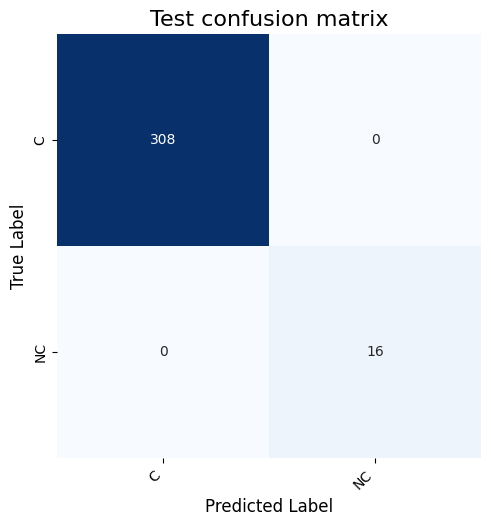

In [27]:
# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred, class_names, ax, title="Test confusion matrix")    
 

#fig.suptitle(f"Confusion Matrix Model {MODEL}", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [28]:
# Comparaison de la liste défaut d'entrée et de celle de sortie
pprint(LISTE_DEFAUT) 
pprint(liste_defaut_crop)

['LH_44421_07_NG.bmp',
 'LH_44285_07_NG - Copie.bmp',
 'LH_39773_07_NG - Copie (2).bmp',
 'LH_46429_07_NG.bmp',
 'LH_42557_07_NG - Copie.bmp',
 'LH_00000_07_NG (3).bmp',
 'LH_44589_07_NG.bmp',
 'LH_44285_07_NG.bmp',
 'LH_00000_07_NG (1).bmp',
 'LH_39773_07_NG.bmp',
 'LH_00000_07_NG (4).bmp',
 'LH_42557_07_NG.bmp',
 'LH_00000_07_NG (5).bmp',
 'LH_00000_07_NG (2).bmp',
 'LH_39773_07_NG - Copie.bmp',
 'LH_46085_07_NG.bmp']
['LH_00000_07_NG (1).bmp',
 'LH_00000_07_NG (2).bmp',
 'LH_00000_07_NG (3).bmp',
 'LH_00000_07_NG (4).bmp',
 'LH_00000_07_NG (5).bmp',
 'LH_39773_07_NG - Copie (2).bmp',
 'LH_39773_07_NG - Copie.bmp',
 'LH_39773_07_NG.bmp',
 'LH_42557_07_NG - Copie.bmp',
 'LH_42557_07_NG.bmp',
 'LH_44285_07_NG - Copie.bmp',
 'LH_44285_07_NG.bmp',
 'LH_44421_07_NG.bmp',
 'LH_44589_07_NG.bmp',
 'LH_46085_07_NG.bmp',
 'LH_46429_07_NG.bmp']


In [29]:
set(liste_defaut_crop)-set(LISTE_DEFAUT)

set()

In [30]:
set(LISTE_DEFAUT)-set(liste_defaut_crop)

set()

In [32]:
import zipfile

# Spécifie le chemin du fichier à zipper et le nom du fichier zip résultant
fichier_a_zipper = model_save_path
fichier_zip = f'/kaggle/working/data/{MODEL}v5.zip'

# Crée un fichier ZIP et ajoute le fichier modèle
with zipfile.ZipFile(fichier_zip, 'w') as zipf:
    zipf.write(fichier_a_zipper, arcname=f'{MODEL}v5.keras')

# Vérifie le contenu du répertoire de travail pour confirmer la création du fichier zip
import os
os.listdir('/kaggle/working/data')

['model_missing_stud_LH07v5.zip', 'DATA_CROP_TRAIN']